In [1]:
from import_images import getImages
from import_model import getModel
from make_predictions import makePredictions
import numpy as np

import torch

from cellpose import resnet_torch
from cellpose import transforms
from cellpose import utils
import cv2

import time

from unet_architecture import UNet
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision
import numpy as np

import matplotlib.pyplot as plt

In [2]:
images_directory = "C:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\pipeline\\uploads\\"
images = getImages(images_directory)
images_torch = torch.from_numpy(np.array(images))

In [3]:
directory = "C:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\datasets\\Fluo-C2DL-Huh7\\01\\models\\CP_20230601_101328"
cpnet = resnet_torch.CPnet(nbase=[2,32,64,128,256],nout=3,sz=3)
cpnet.load_model(directory)

In [4]:
def get_pre_activations(image,cpnet):
    rescale = cpnet.diam_mean/cpnet.diam_labels
    shape1, shape2 = image.shape[0], image.shape[1]

    x = transforms.resize_image(image, rsz=rescale,no_channels=True)
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)
    x = np.concatenate((x, x), axis=0)
    x = torch.from_numpy(x)
    x = x.unsqueeze(0)

    downsample = cpnet.downsample(x)
    downsample_return = downsample[1].squeeze(0)
    downsample_return = downsample_return.cpu().detach().numpy().tolist()

    for (k, image) in enumerate(downsample_return):
        downsample_return[k] = cv2.resize(np.array(image), dsize=(512, 512), interpolation=cv2.INTER_NEAREST)
    downsample_return = np.array(downsample_return)
    downsample_return = torch.from_numpy(downsample_return)


    style = cpnet.make_style(downsample[-1])
    upsample = cpnet.upsample(style, downsample, cpnet.mkldnn)

    output = cpnet.output(upsample)
    output = output.squeeze(0)
    output = output[2]
    
    print(output.shape)
    output = output.cpu().detach().numpy().tolist()
    output = cv2.resize(np.array(output), dsize=(1024, 1024), interpolation=cv2.INTER_NEAREST)
    output = np.array(output)
    output = torch.from_numpy(output)

    upsample = upsample.squeeze(0)
    upsample = upsample.cpu().detach().numpy().tolist()
    for (k, image) in enumerate(upsample):
        upsample[k] = cv2.resize(np.array(image), dsize=(1024, 1024), interpolation=cv2.INTER_NEAREST)
    upsample = np.array(upsample)
    upsample = torch.from_numpy(upsample)

    return downsample_return, upsample, output

In [5]:
downsample_return, upsample, output = get_pre_activations(images[0],cpnet)

print(downsample_return.shape, upsample.shape, output.shape)

torch.Size([536, 536])
torch.Size([64, 512, 512]) torch.Size([32, 1024, 1024]) torch.Size([1024, 1024])


In [6]:
unet = UNet(encChannels=(1, 32, 64), decChannels=(64, 32))
downsample, upsample, output = unet(images_torch[0].unsqueeze(0).unsqueeze(0))
print(downsample[-1].shape, upsample.shape, output.shape)

torch.Size([1, 64, 512, 512]) torch.Size([1, 32, 1024, 1024]) torch.Size([1, 1, 1024, 1024])


In [7]:
print(downsample[2].shape)

IndexError: list index out of range

In [8]:
cp_downsamples = []
cp_upsamples = []
cp_outputs = []
for image in images:
    downsample, upsample, output = get_pre_activations(image,cpnet)
    print('downsample shape',downsample.shape)
    print('upsample shape',upsample.shape)
    print('output shape',output.shape)
    cp_downsamples.append(downsample)
    cp_upsamples.append(upsample)
    cp_outputs.append(output)

torch.Size([536, 536])
downsample shape torch.Size([64, 512, 512])
upsample shape torch.Size([32, 1024, 1024])
output shape torch.Size([1024, 1024])
torch.Size([536, 536])
downsample shape torch.Size([64, 512, 512])
upsample shape torch.Size([32, 1024, 1024])
output shape torch.Size([1024, 1024])
torch.Size([536, 536])
downsample shape torch.Size([64, 512, 512])
upsample shape torch.Size([32, 1024, 1024])
output shape torch.Size([1024, 1024])
torch.Size([536, 536])
downsample shape torch.Size([64, 512, 512])
upsample shape torch.Size([32, 1024, 1024])
output shape torch.Size([1024, 1024])
torch.Size([536, 536])
downsample shape torch.Size([64, 512, 512])
upsample shape torch.Size([32, 1024, 1024])
output shape torch.Size([1024, 1024])
torch.Size([536, 536])
downsample shape torch.Size([64, 512, 512])
upsample shape torch.Size([32, 1024, 1024])
output shape torch.Size([1024, 1024])
torch.Size([536, 536])
downsample shape torch.Size([64, 512, 512])
upsample shape torch.Size([32, 1024, 10

In [9]:
class ImageDataset(Dataset):
    def __init__(self, image, downsample, upsample, cellprob):
        self.image = image
        self.downsample = downsample
        self.upsample = upsample
        self.cellprob = cellprob

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        img = self.image[idx]
        downsample = self.downsample[idx]
        upsample = self.upsample[idx]
        cellprob = self.cellprob[idx]
        return image, downsample, upsample, cellprob

images_torch_rotated = []
for image in images_torch:
    images_torch_rotated.append(image)
    for i in range(3):
        image = torch.rot90(image, 1, [0, 1])
        images_torch_rotated.append(image)

images_torch_rotated_flipped = []
for image in images_torch_rotated:
    images_torch_rotated_flipped.append(image)
    images_torch_rotated_flipped.append(torch.flip(image, [1]))

cp_downsamples_rotated = []
for downsample in cp_downsamples:
    cp_downsamples_rotated.append(downsample)
    for i in range(3):
        downsample = torch.rot90(downsample, 1, [1, 2])
        cp_downsamples_rotated.append(downsample)

cp_upsamples_rotated = []
for upsample in cp_upsamples:
    cp_upsamples_rotated.append(upsample)
    for i in range(3):
        upsample = torch.rot90(upsample, 1, [1, 2])
        cp_upsamples_rotated.append(upsample)

cp_upsamples_rotated_flipped = []
for upsample in cp_upsamples_rotated:
    cp_upsamples_rotated_flipped.append(upsample)
    cp_upsamples_rotated_flipped.append(torch.flip(upsample, [2]))

cp_outputs_rotated = []
for output in cp_outputs:
    cp_outputs_rotated.append(output)
    for i in range(3):
        output = torch.rot90(output, 1, [0, 1])
        cp_outputs_rotated.append(output)

cp_outputs_rotated_flipped = []
for output in cp_outputs_rotated:
    cp_outputs_rotated_flipped.append(output)
    cp_outputs_rotated_flipped.append(torch.flip(output, [1]))

train_dataset = ImageDataset(images_torch[:1], cp_downsamples[:1], cp_upsamples[:1], cp_outputs[:1])
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

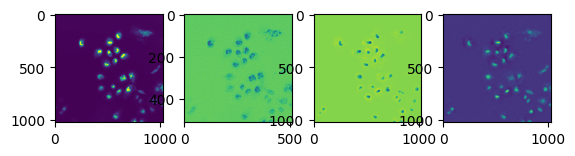

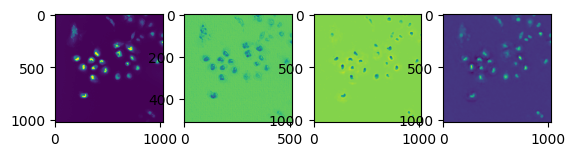

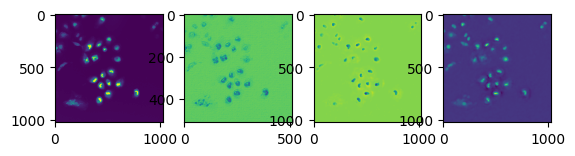

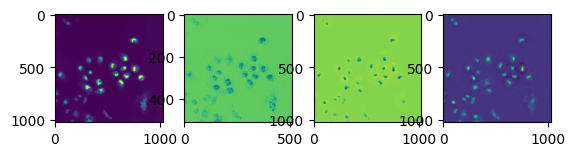

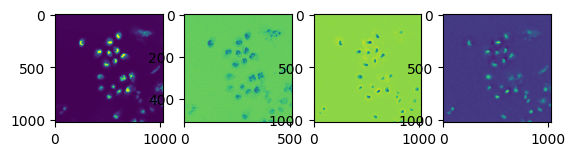

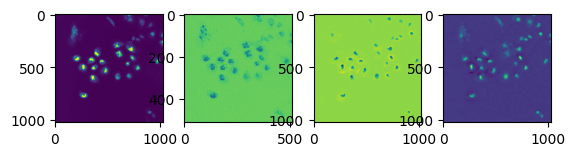

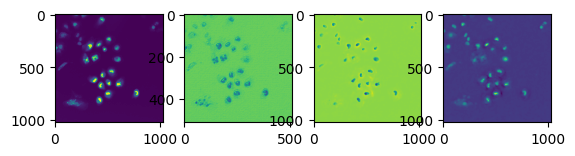

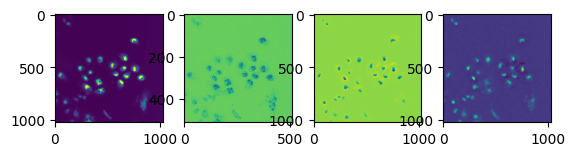

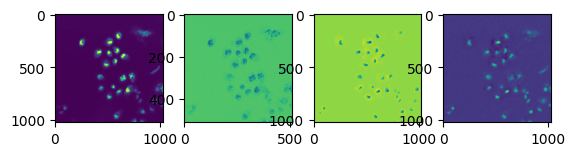

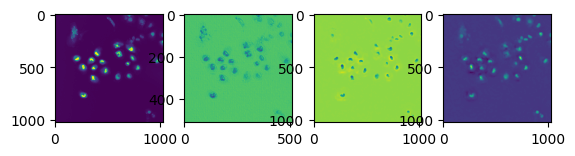

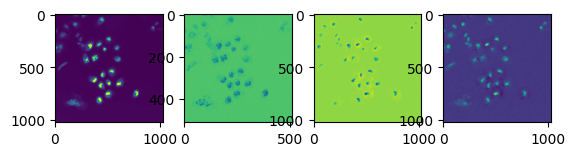

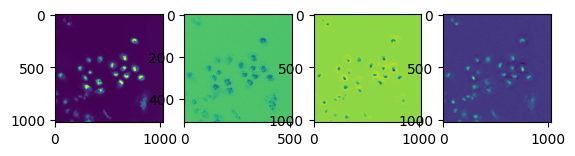

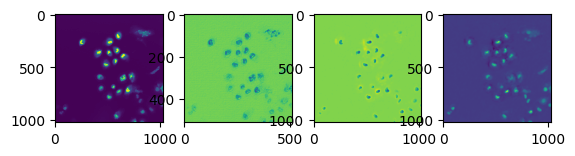

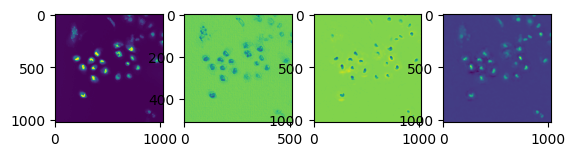

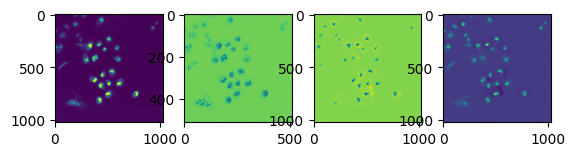

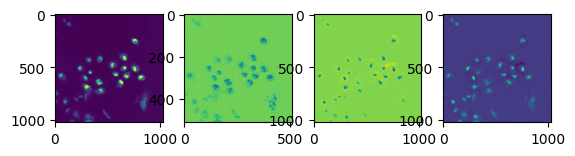

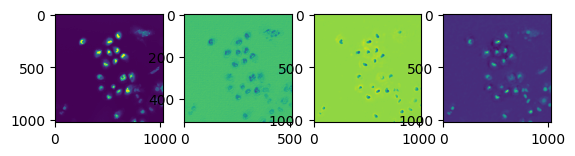

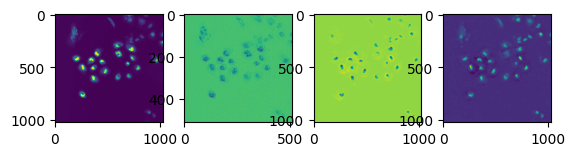

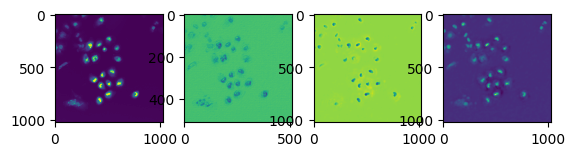

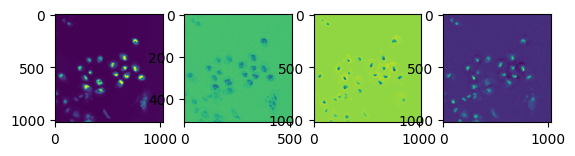

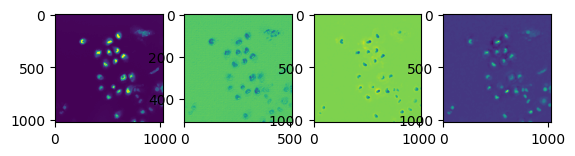

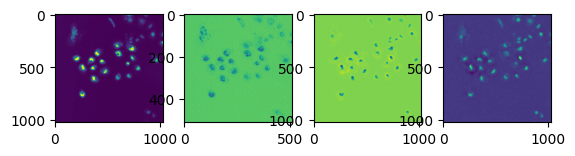

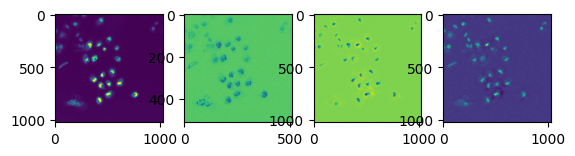

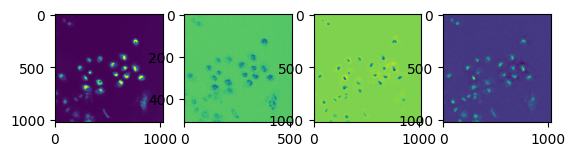

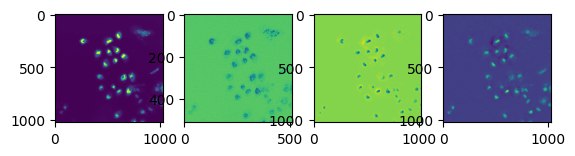

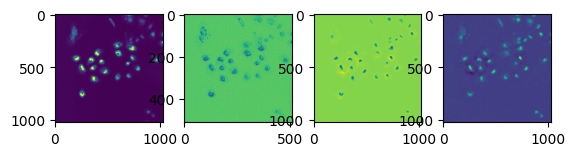

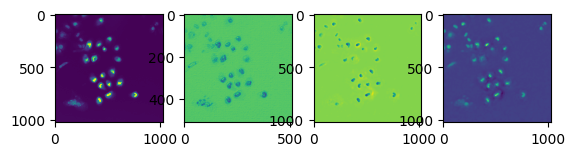

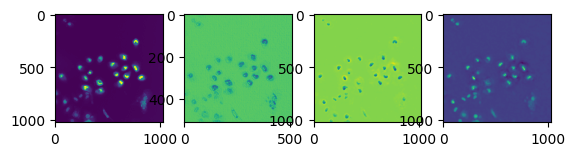

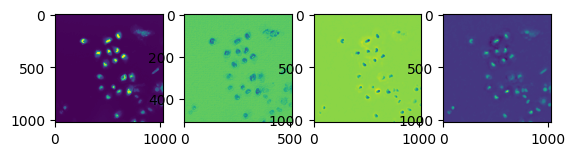

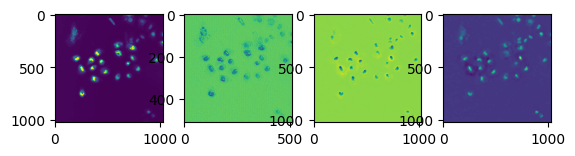

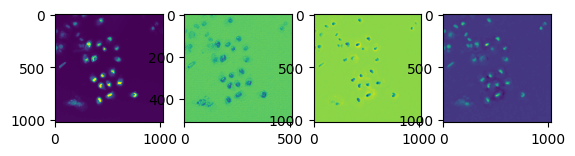

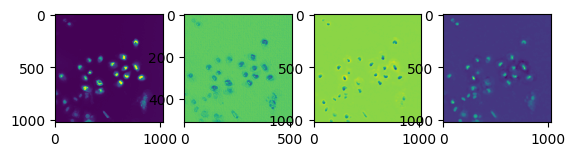

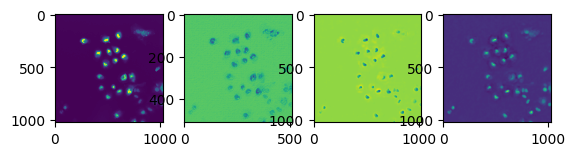

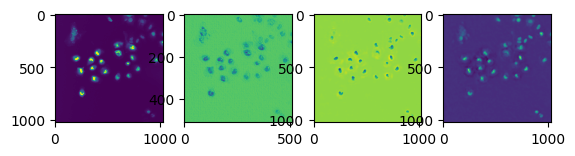

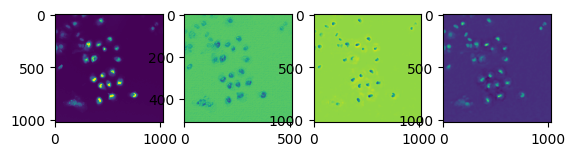

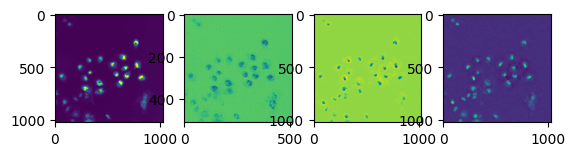

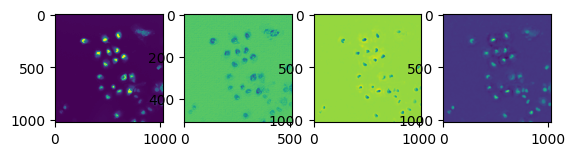

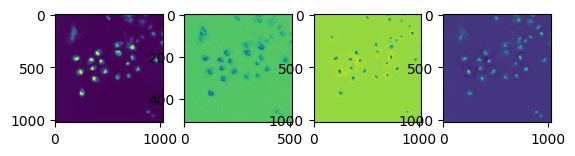

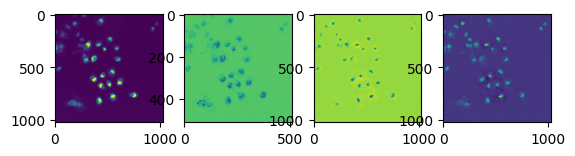

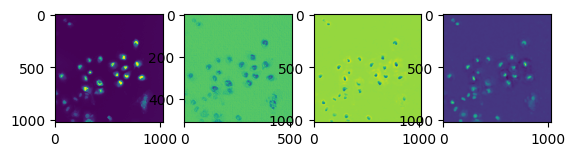

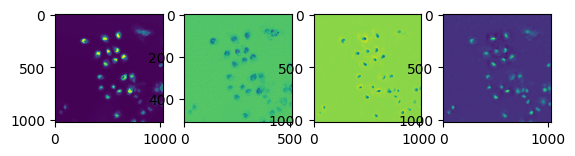

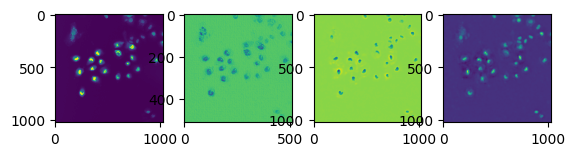

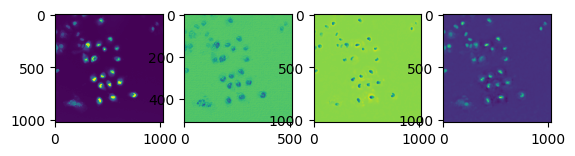

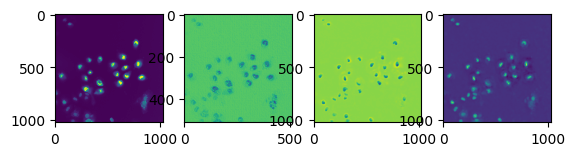

In [10]:
for i in range(len(images_torch_rotated)):
    plt.subplot(1,4,1)
    plt.imshow(images_torch_rotated[i])
    plt.subplot(1,4,2)
    plt.imshow(cp_downsamples_rotated[i][10])
    plt.subplot(1,4,3)
    plt.imshow(cp_upsamples_rotated[i][10])
    plt.subplot(1,4,4)
    plt.imshow(cp_outputs_rotated[i])
    plt.show()

In [11]:
class KDLoss(torch.nn.Module):
    def __init__(self, alpha = 0.5, beta = 1.0, temperature=1):
        super(KDLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.temperature = temperature

    def forward(self, y_16_pred, y_32_pred, y_3_pred, y_16_true, y_32_true, y_3_true):

        y_16_pred = F.sigmoid(y_16_pred)
        y_16_true = F.sigmoid(y_16_true)
        #print(y_16_pred.shape, y_16_true.shape)
        y_16_loss = F.mse_loss(y_16_pred, y_16_true.float())

        y_32_pred = F.sigmoid(y_32_pred)
        y_32_true = F.sigmoid(y_32_true)
        y_32_loss = F.mse_loss(y_32_pred, y_32_true.float())

        y_3_pred = F.sigmoid(y_3_pred)
        y_3_true = F.sigmoid(y_3_true)
        y_3_loss = F.mse_loss(y_3_pred, y_3_true.float())

        y_3_pred_binary = torch.where(y_3_pred > 0.1, torch.ones_like(y_3_pred), torch.zeros_like(y_3_pred))
        y_3_true_binary = torch.where(y_3_true > 0.1, torch.ones_like(y_3_true), torch.zeros_like(y_3_true))
        y_3_pred_binary = y_3_pred_binary.float()
        y_3_true_binary = y_3_true_binary.float()
        y_3_binary_loss = F.binary_cross_entropy(y_3_pred_binary, y_3_true_binary)

        loss = 0.0 * y_16_loss + 1.0 * y_32_loss + 1.0 * y_3_loss + 0.0 * y_3_binary_loss
        return loss

In [12]:
def trainEpoch(unet, train_loader, loss_fn, optimiser, scheduler, epoch_num):
    time_start = time.time()
    
    unet.train()

    train_loss = 0
    for image, donwsample_cp, upsample, cp_output in train_loader:
        (image, donwsample_cp, upsample, cp_output) = (image.to('cuda:0'),donwsample_cp.to('cuda:0'),upsample.to('cuda:0'),cp_output.to('cuda:0')) # sending the data to the device (cpu or GPU)

        image = image.unsqueeze(1)
        y_16_pred, y_32_pred, y_3_pred = unet(image)
        y_16_pred = y_16_pred[-1].squeeze(1)
        y_32_pred = y_32_pred.squeeze(1)
        y_3_pred = y_3_pred.squeeze(1)
        
        #pred, predicted_masks, cellprob, cellmask = pred.squeeze(0), predicted_masks.float().squeeze(0), cellprob.squeeze(0), cellmask.squeeze(0)

        loss = loss_fn(y_16_pred, y_32_pred, y_3_pred,donwsample_cp,  upsample, cp_output) # calculate the loss of that prediction

        train_loss += loss
        optimiser.zero_grad() # zero out the accumulated gradients
        loss.backward() # backpropagate the loss
        optimiser.step() # update model parameters
        if scheduler is not None:
            scheduler.step()
    train_loss = train_loss.item()/len(train_loader)

    if epoch_num is None:
        print('Training loss: ', train_loss, 'Time: ', time.time()-time_start)
    else:
        print('Epoch ', epoch_num, 'Training loss: ', train_loss, 'Time: ', time.time()-time_start)

    return unet

In [13]:
unet = UNet(encChannels=(1, 32, 64), decChannels=(64, 32))
unet = unet.to('cuda:0')
loss_fn = KDLoss()
optimiser = torch.optim.SGD(unet.parameters(), lr=0.1, momentum=0.1)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimiser, base_lr=0.00001, max_lr=0.1)

for epoch in range(1000):
    unet = trainEpoch(unet, train_loader, loss_fn, optimiser, scheduler=scheduler, epoch_num=epoch)

c:\Users\rz200\AppData\Local\anaconda3\envs\cellprob\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch  0 Training loss:  0.33229491114616394 Time:  2.7327232360839844
Epoch  1 Training loss:  0.33229419589042664 Time:  0.28870368003845215
Epoch  2 Training loss:  0.33228594064712524 Time:  0.2858879566192627
Epoch  3 Training loss:  0.33226436376571655 Time:  0.2899355888366699
Epoch  4 Training loss:  0.3322245478630066 Time:  0.2860720157623291
Epoch  5 Training loss:  0.3321623206138611 Time:  0.28760647773742676
Epoch  6 Training loss:  0.33207419514656067 Time:  0.291104793548584
Epoch  7 Training loss:  0.33195725083351135 Time:  0.2916586399078369
Epoch  8 Training loss:  0.33180904388427734 Time:  0.28831005096435547
Epoch  9 Training loss:  0.33162766695022583 Time:  0.28688621520996094
Epoch  10 Training loss:  0.3314114212989807 Time:  0.2922532558441162
Epoch  11 Training loss:  0.3311590552330017 Time:  0.29108238220214844
Epoch  12 Training loss:  0.33086955547332764 Time:  0.2900547981262207
Epoch  13 Training loss:  0.33054211735725403 Time:  0.28962230682373047
E

KeyboardInterrupt: 

In [14]:
torch.save(unet.state_dict(), "C:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\pipeline\\models\\model12")

In [15]:
for image, downsample, upsample, cp_output in train_loader:
    (image,downsample,upsample,cp_output) = (image.to('cuda:0'),downsample.to('cuda:0'),upsample.to('cuda:0'),cp_output.to('cuda:0')) # sending the data to the device (cpu or GPU)

    #image = image.unsqueeze(1)
    image = image.squeeze(0).squeeze(0).squeeze(0)
    image = image.unsqueeze(0)
    print(image.shape)
    unet = unet.to('cuda:0')
    y_16_pred, y_32_pred, y_3_pred = unet(image)

    y_3_pred = F.sigmoid(y_3_pred)
    y_3_pred = y_3_pred.cpu().detach().numpy()
    y_3_pred = y_3_pred.squeeze(0)

    cp_output = cp_output[0]
    cp_output = F.sigmoid(cp_output)
    cp_output = cp_output.cpu().detach().numpy()

    plt.subplot(1,2,1)
    plt.imshow(y_3_pred[0])
    plt.subplot(1,2,2)
    plt.imshow(cp_output)
    plt.show()

torch.Size([1, 1024, 1024])


ValueError: not enough values to unpack (expected 4, got 3)

In [ ]:
print(y_3_pred)
print(cp_output)

[[[0.17437321 0.1328467  0.12307188 ... 0.15353833 0.18278918 0.24028839]
  [0.12996836 0.07778236 0.06630962 ... 0.09720141 0.12899849 0.20043756]
  [0.11184072 0.05966778 0.04746874 ... 0.07730888 0.10918865 0.1835386 ]
  ...
  [0.11115183 0.05722518 0.04319654 ... 0.04973401 0.07799228 0.15244113]
  [0.13702697 0.07916072 0.06244636 ... 0.06345615 0.09189302 0.16312632]
  [0.20011707 0.14557485 0.12731823 ... 0.12318537 0.1500321  0.20565869]]]
[[0.00029434 0.00029434 0.00035585 ... 0.00036531 0.00036531 0.00040867]
 [0.00029434 0.00029434 0.00035585 ... 0.00036531 0.00036531 0.00040867]
 [0.00030379 0.00030379 0.00025264 ... 0.00030516 0.00030516 0.00030033]
 ...
 [0.00025675 0.00025675 0.0001907  ... 0.00017275 0.00017275 0.00022976]
 [0.00025675 0.00025675 0.0001907  ... 0.00017275 0.00017275 0.00022976]
 [0.00023637 0.00023637 0.00018916 ... 0.00026143 0.00026143 0.00015509]]


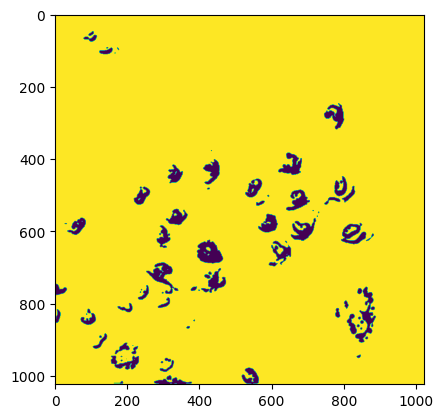

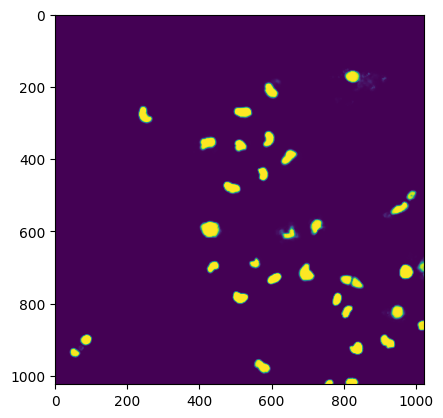

In [ ]:
y_3_pred_0 = y_3_pred[0]
y_3_pred_bin = np.where(y_3_pred_0 > 0.01, 1, 0)
plt.imshow(y_3_pred_bin)
plt.show()

plt.imshow(cp_output)
plt.show()

In [ ]:
from cellpose import dynamics

dynamics.get_masks(y_3_pred)

IndexError: list index out of range

In [ ]:
#sigmoid numpy array y_3_pred
y_3_pred_2_sig = 1/(1+np.exp(-y_3_pred[2]))
print(np.unique(y_3_pred_2_sig))
y_3_pred_2_sig_binary = np.where(y_3_pred_2_sig>0.1,1,0)
print(np.unique(y_3_pred_2_sig_binary))
plt.imshow(y_3_pred_2_sig_binary)
plt.show()

In [ ]:
unet = UNet(nbClasses=3)
decfeatures, pred = unet(torch.from_numpy(images[0]).unsqueeze(0).unsqueeze(0))
print(decfeatures.shape, pred.shape)